
--- GM Summary (252 Trading Days) ---
Start Price:         $46.46
Final Simulated:     $47.62 → Return: 2.49%
Final Actual:        $52.89 → Return: 13.84%


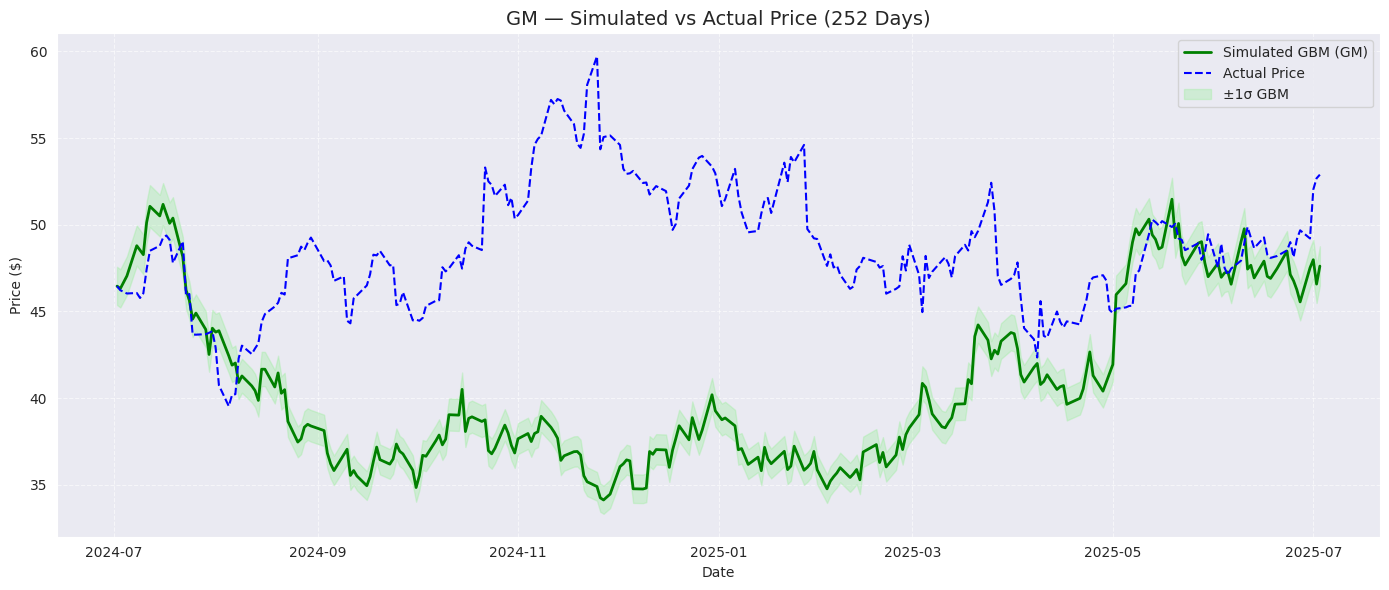

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import datetime

# --- Input Section ---
ticker_symbol = input("Enter stock ticker (default: MSFT): ") or "MSFT"

# --- Fetch historical data over ~400 days to ensure ~250 trading days ---
end_date = datetime.datetime.today()
start_date = end_date - datetime.timedelta(days=400)

stock = yf.Ticker(ticker_symbol)
history = stock.history(start=start_date, end=end_date)

# Use as many trading days as available (up to 252 max for consistency)
available_days = min(len(history), 252)

if available_days < 50:
    raise ValueError(f"{ticker_symbol}: Only {available_days} trading days of data available. Try a different ticker.")

# --- Extract actual prices and dates ---
actual_prices = history['Close'].values[-available_days:]
dates = history.index[-available_days:]
start_price = actual_prices[0]

# --- Compute drift and volatility from log returns ---
log_returns = np.log(actual_prices[1:] / actual_prices[:-1])
mu = np.mean(log_returns) * available_days
sigma = np.std(log_returns) * np.sqrt(available_days)

# --- Simulate GBM ---
dt = 1 / available_days
np.random.seed(42)
shocks = np.random.normal(0, 1, available_days)

sim_prices = np.zeros(available_days)
sim_prices[0] = start_price

for t in range(1, available_days):
    sim_prices[t] = sim_prices[t - 1] * np.exp((mu - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * shocks[t])

# --- ±1σ Bounds ---
upper_bound = sim_prices * np.exp(sigma * np.sqrt(dt))
lower_bound = sim_prices * np.exp(-sigma * np.sqrt(dt))

# --- Plot ---
plt.figure(figsize=(14, 6))
plt.plot(dates, sim_prices, label=f"Simulated GBM ({ticker_symbol})", color="green", lw=2)
plt.plot(dates, actual_prices, label="Actual Price", color="blue", linestyle="--")
plt.fill_between(dates, lower_bound, upper_bound, color="lightgreen", alpha=0.3, label="±1σ GBM")

plt.title(f"{ticker_symbol} — Simulated vs Actual Price ({available_days} Days)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# --- Print Summary ---
sim_return = (sim_prices[-1] - sim_prices[0]) / sim_prices[0] * 100
actual_return = (actual_prices[-1] - actual_prices[0]) / actual_prices[0] * 100

print(f"\n--- {ticker_symbol} Summary ({available_days} Trading Days) ---")
print(f"Start Price:         ${start_price:.2f}")
print(f"Final Simulated:     ${sim_prices[-1]:.2f} → Return: {sim_return:.2f}%")
print(f"Final Actual:        ${actual_prices[-1]:.2f} → Return: {actual_return:.2f}%")

plt.show()


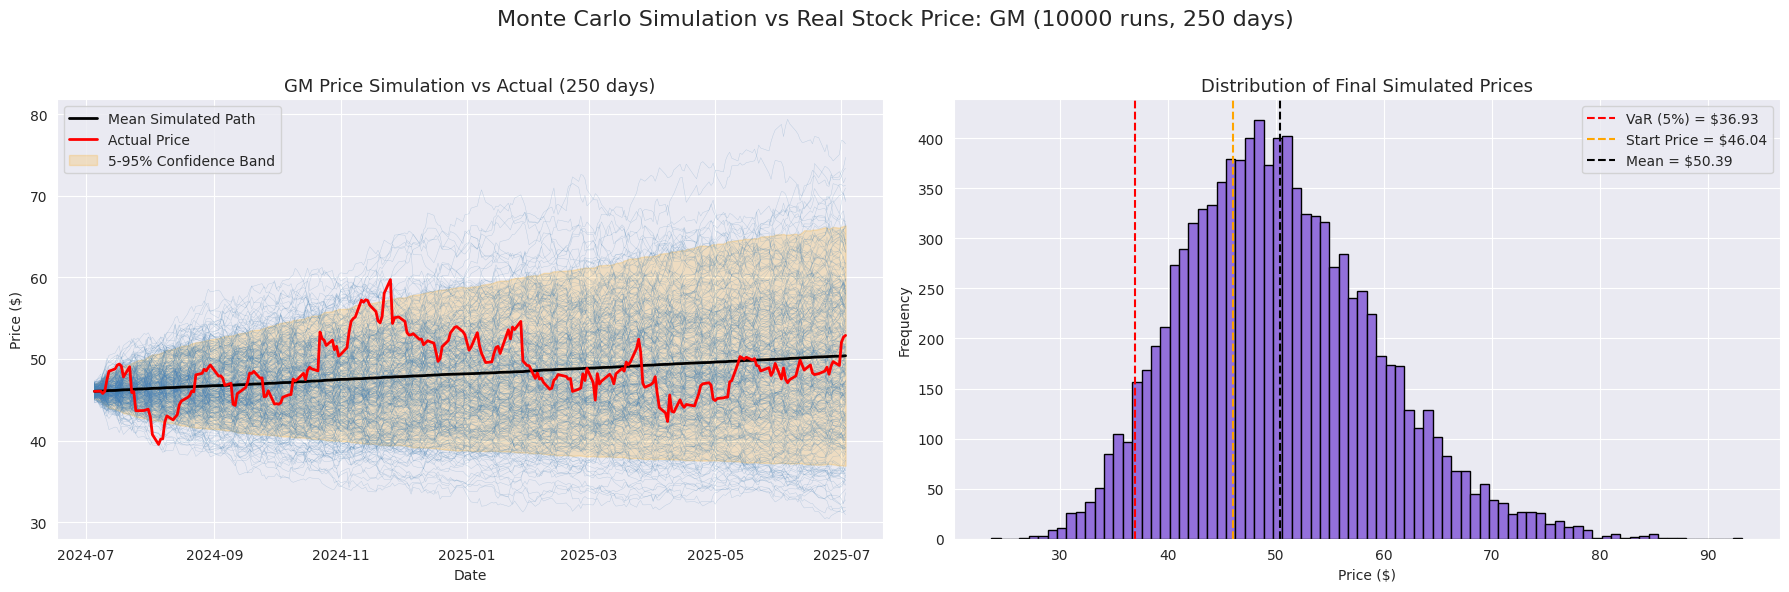

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns
import pandas as pd

# --- Style Settings ---
sns.set_style("darkgrid")

# --- Fetch Historical Price Data ---
def fetch_historical_prices(symbol, period="1y"):
    stock = yf.Ticker(symbol)
    hist = stock.history(period=period)
    if hist.empty or len(hist) < 200:
        raise ValueError(f"{symbol}: Only {len(hist)} days of data available. Try another ticker.")
    return hist['Close']

# --- Input ---
input_symbol = input("Enter stock ticker (default: MSFT): ") or "MSFT"
try:
    actual_prices = fetch_historical_prices(input_symbol)
except ValueError as e:
    print(e)
    input_symbol = "AAPL"
    actual_prices = fetch_historical_prices(input_symbol)

# --- Adjust based on available days ---
actual_prices = actual_prices[-min(len(actual_prices), 252):]  # clip to max 252
steps = len(actual_prices)
dates = actual_prices.index
base_price = actual_prices.iloc[0]

# --- GBM Parameters ---
drift = 0.09
volatility = 0.18
dt = 1 / steps
simulations = 10000

# --- Simulation ---
np.random.seed(0)
shocks = np.random.normal(0, 1, (simulations, steps))
paths = np.zeros((simulations, steps + 1))
paths[:, 0] = base_price

for t in range(1, steps + 1):
    paths[:, t] = paths[:, t - 1] * np.exp(
        (drift - 0.5 * volatility ** 2) * dt + volatility * np.sqrt(dt) * shocks[:, t - 1]
    )

final_prices = paths[:, -1]
mean_path = paths.mean(axis=0)
VaR_95 = np.percentile(final_prices, 5)
prob_loss = np.mean(final_prices < base_price)

# --- Plotting ---
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Left: Simulation paths + actual prices
for i in range(300):
    axs[0].plot(dates.insert(0, dates[0]), paths[i], color='steelblue', linewidth=0.3, alpha=0.3)

axs[0].plot(dates.insert(0, dates[0]), mean_path, color='black', linewidth=2, label="Mean Simulated Path")
axs[0].plot(dates, actual_prices.values, color='red', linewidth=2, label="Actual Price")
axs[0].fill_between(dates.insert(0, dates[0]), 
                    np.percentile(paths, 5, axis=0), 
                    np.percentile(paths, 95, axis=0),
                    color='orange', alpha=0.2, label="5-95% Confidence Band")

axs[0].set_title(f"{input_symbol} Price Simulation vs Actual ({steps} days)", fontsize=13)
axs[0].set_xlabel("Date")
axs[0].set_ylabel("Price ($)")
axs[0].legend()
axs[0].grid(True)

# Right: Final Price Histogram
axs[1].hist(final_prices, bins=80, color='mediumpurple', edgecolor='black')
axs[1].axvline(VaR_95, color='red', linestyle='--', label=f"VaR (5%) = ${VaR_95:.2f}")
axs[1].axvline(base_price, color='orange', linestyle='--', label=f"Start Price = ${base_price:.2f}")
axs[1].axvline(np.mean(final_prices), color='black', linestyle='--', label=f"Mean = ${np.mean(final_prices):.2f}")

axs[1].set_title("Distribution of Final Simulated Prices", fontsize=13)
axs[1].set_xlabel("Price ($)")
axs[1].set_ylabel("Frequency")
axs[1].legend()
axs[1].grid(True)

plt.suptitle(f"Monte Carlo Simulation vs Real Stock Price: {input_symbol} ({simulations} runs, {steps} days)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


✅ Using tickers: ['AAPL', 'TSLA', 'MSFT']


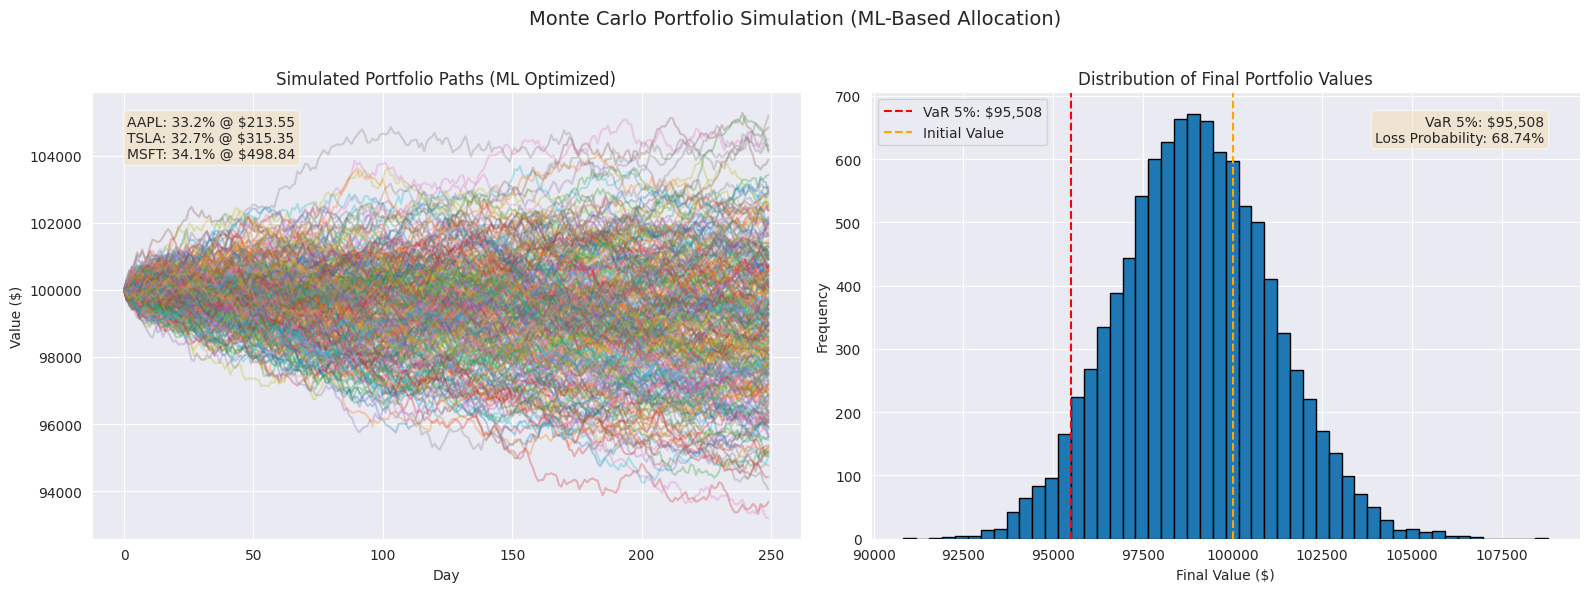

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
import pandas as pd

# --- User Input ---
tickers_input = input("Enter comma-separated tickers (e.g., AAPL, TSLA, MSFT): ")
tickers = [t.strip().upper() for t in tickers_input.split(',') if t.strip()]
print("✅ Using tickers:", tickers)

# --- Download Price Data ---
def fetch_prices(ticker):
    return yf.Ticker(ticker).history(period="1y")["Close"]

price_data = []
valid_tickers = []
for ticker in tickers:
    try:
        series = fetch_prices(ticker)
        if len(series) >= 200:
            price_data.append(series)
            valid_tickers.append(ticker)
        else:
            print(f"⚠️ {ticker} has insufficient data.")
    except Exception as e:
        print(f"⚠️ Failed to fetch data for {ticker}: {e}")

tickers = valid_tickers
prices_df = pd.concat(price_data, axis=1)
prices_df.columns = tickers
prices_df.dropna(inplace=True)

prices = prices_df.values
returns = np.log(prices[1:] / prices[:-1])
mu = np.mean(returns, axis=0) * 252
sigma = np.std(returns, axis=0) * np.sqrt(252)
cov_matrix = np.cov(returns.T)
S0 = prices[-1, :]
n_assets = len(tickers)

# --- ML Optimization ---
X_train = []
Y_train = []
for _ in range(1000):
    w = np.random.dirichlet(np.ones(n_assets))
    port_return = np.dot(w, mu)
    port_vol = np.sqrt(np.dot(w.T, np.dot(cov_matrix, w)))
    sharpe = (port_return - 0.03) / port_vol
    X_train.append(np.concatenate([mu, sigma]))
    Y_train.append(w)

X_train = np.array(X_train)
Y_train = np.array(Y_train)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
model = Ridge(alpha=0.1)
model.fit(X_scaled, Y_train)

X_input = scaler.transform([np.concatenate([mu, sigma])])
weights = model.predict(X_input)[0]
weights /= np.sum(weights)

# --- Simulation ---
T = 1
N = min(252, prices.shape[0] - 1)
M = 10000
dt = T / N

L = np.linalg.cholesky(cov_matrix)
price_paths = np.zeros((M, N + 1, n_assets))
price_paths[:, 0, :] = S0

for m in range(M):
    Z = np.random.normal(size=(N, n_assets))
    correlated_Z = Z @ L.T
    for t in range(1, N + 1):
        drift = (mu - 0.5 * sigma**2) * dt
        diffusion = np.sqrt(dt) * correlated_Z[t - 1]
        price_paths[m, t, :] = price_paths[m, t - 1, :] * np.exp(drift + diffusion)

portfolio_values = np.sum(price_paths * weights, axis=2)
initial_value = np.sum(S0 * weights)
portfolio_values *= (100000 / initial_value)

final_vals = portfolio_values[:, -1]
VaR_95 = np.percentile(final_vals, 5)
loss_prob = np.mean(final_vals < 100000) * 100

# --- Plotting ---
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Left: Simulated Paths
for i in range(300):
    axs[0].plot(portfolio_values[i], alpha=0.3)
axs[0].set_title("Simulated Portfolio Paths (ML Optimized)")
axs[0].set_xlabel("Day")
axs[0].set_ylabel("Value ($)")
axs[0].grid(True)

# Display Weights
weight_text = "\n".join([f"{tickers[i]}: {weights[i]*100:.1f}% @ ${S0[i]:.2f}" for i in range(n_assets)])
axs[0].text(0.05, 0.95, weight_text, transform=axs[0].transAxes,
            fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Right: Histogram
axs[1].hist(final_vals, bins=50, edgecolor='black')
axs[1].set_title("Distribution of Final Portfolio Values")
axs[1].set_xlabel("Final Value ($)")
axs[1].set_ylabel("Frequency")
axs[1].grid(True)

axs[1].axvline(VaR_95, color='red', linestyle='--', label=f"VaR 5%: ${VaR_95:,.0f}")
axs[1].axvline(100000, color='orange', linestyle='--', label='Initial Value')
axs[1].legend()

risk_text = f"VaR 5%: ${VaR_95:,.0f}\nLoss Probability: {loss_prob:.2f}%"
axs[1].text(0.95, 0.95, risk_text, transform=axs[1].transAxes,
            fontsize=10, verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle("Monte Carlo Portfolio Simulation (ML-Based Allocation)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
